# Face Recognition Multi-Model Training on LFW - PART 2
## Training Multiple Models with Deep Learning Backbones and Classical/Neural Classifier Heads

This notebook trains multiple face identification models and compares their performance.
- **Task**: Face Identification (multi-class classification)
- **Backbones (Part 2)**: VGG16, ResNet101, EfficientNet-B3
- **Neural Heads**: Simple, MLP, Deep, Attention, CosFace
- **Classical Classifiers**: SVM (RBF & Linear), Random Forest, XGBoost
- **Output**: Best model for video face recognition + JSON results file
- **Hardware**: Optimized for Kaggle 2x Tesla T4 GPU with DataParallel support
- **Epochs**: 10 per model

In [1]:
import os
import gc
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
import json
import time
import joblib
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, classification_report, top_k_accuracy_score,
                             roc_auc_score, roc_curve, auc, log_loss)

# Optional XGBoost
try:
    import xgboost as xgb
    HAS_XGB = True
    print("✓ XGBoost available")
except ImportError:
    HAS_XGB = False
    print("✗ XGBoost not available - will skip XGBoost classifiers")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
# GPU SETUP - OPTIMIZED FOR 2x TESLA T4
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_gpus = torch.cuda.device_count()

print(f"\n{'='*60}")
print("HARDWARE CONFIGURATION")
print(f"{'='*60}")
print(f"Device: {device}")
print(f"Number of GPUs: {n_gpus}")

if n_gpus > 0:
    for i in range(n_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        print(f"  GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")
        
        # Check if Tesla T4 for optimized settings
        if 'T4' in gpu_name:
            print(f"    → Tesla T4 detected! Using optimized settings.")
            torch.backends.cudnn.benchmark = True  # Enable for T4 optimization

print(f"{'='*60}")

✓ XGBoost available

HARDWARE CONFIGURATION
Device: cuda
Number of GPUs: 2
  GPU 0: Tesla T4 (15.6 GB)
    → Tesla T4 detected! Using optimized settings.
  GPU 1: Tesla T4 (15.6 GB)
    → Tesla T4 detected! Using optimized settings.


In [2]:
# ============================================================
# KAGGLE CONFIGURATION
# ============================================================
# Set this to True when running on Kaggle
RUNNING_ON_KAGGLE = True

if RUNNING_ON_KAGGLE:
    # Data is already extracted on Kaggle at this path
    DATA_DIR = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
    WORK_DIR = '/kaggle/working'
    MODELS_DIR = os.path.join(WORK_DIR, 'models_part2')
else:
    # Local paths
    WORK_DIR = '../outputs'
    DATA_DIR = '../data/lfw-deepfunneled/lfw-deepfunneled'
    MODELS_DIR = '../models/checkpoints_part2'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Working directory: {WORK_DIR}")
print(f"Models directory: {MODELS_DIR}")

Data directory: /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
Working directory: /kaggle/working
Models directory: /kaggle/working/models_part2


In [3]:
# Verify data exists
if os.path.exists(DATA_DIR):
    num_people = len([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    print(f"✓ Data found at {DATA_DIR}")
    print(f"  Total people directories: {num_people}")
else:
    raise FileNotFoundError(f"Data not found at {DATA_DIR}. Please check the path.")

✓ Data found at /kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled
  Total people directories: 5749


## 1. Data Loading and Preprocessing

In [4]:
# Configuration
MIN_IMAGES_PER_PERSON = 10  # Only include people with >= N images
MAX_PEOPLE = 100  # Limit to top N people (None for all)
VAL_SPLIT = 0.2
IMG_SIZE = 224
BATCH_SIZE = 32 * max(1, n_gpus)  # Scale batch size with GPUs

print(f"Batch size: {BATCH_SIZE}")
print(f"Min images per person: {MIN_IMAGES_PER_PERSON}")
print(f"Max people: {MAX_PEOPLE}")

Batch size: 64
Min images per person: 10
Max people: 100


In [5]:
def load_lfw_dataset(data_dir, min_images=10, max_people=None):
    """Load LFW dataset for face identification."""
    people_dirs = sorted([d for d in os.listdir(data_dir) 
                          if os.path.isdir(os.path.join(data_dir, d))])
    
    # Count images per person
    person_counts = {}
    for person in people_dirs:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        if len(images) >= min_images:
            person_counts[person] = len(images)
    
    # Sort by count and limit
    sorted_people = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)
    if max_people:
        sorted_people = sorted_people[:max_people]
    
    # Create class mapping
    class_names = [p[0] for p in sorted_people]
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    for person in class_names:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith('.jpg')]
        for img in images:
            image_paths.append(os.path.join(person_path, img))
            labels.append(class_to_idx[person])
    
    return image_paths, labels, class_names

# Load dataset
image_paths, labels, class_names = load_lfw_dataset(
    DATA_DIR, 
    min_images=MIN_IMAGES_PER_PERSON,
    max_people=MAX_PEOPLE
)

num_classes = len(class_names)
print(f"\nTotal images: {len(image_paths)}")
print(f"Number of classes (people): {num_classes}")
print(f"\nFirst 10 people: {class_names[:10]}")


Total images: 3651
Number of classes (people): 100

First 10 people: ['George_W_Bush', 'Colin_Powell', 'Tony_Blair', 'Donald_Rumsfeld', 'Gerhard_Schroeder', 'Ariel_Sharon', 'Hugo_Chavez', 'Junichiro_Koizumi', 'Jean_Chretien', 'John_Ashcroft']


In [6]:
# Train/Val split
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, 
    test_size=VAL_SPLIT, 
    stratify=labels, 
    random_state=SEED
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

Training samples: 2920
Validation samples: 731


In [7]:
# Dataset class
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Transforms - EXACT SAME AS REFERENCE
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = FaceDataset(X_train, y_train, transform=train_transform)
val_dataset = FaceDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=4, pin_memory=True, drop_last=True
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 45
Val batches: 12


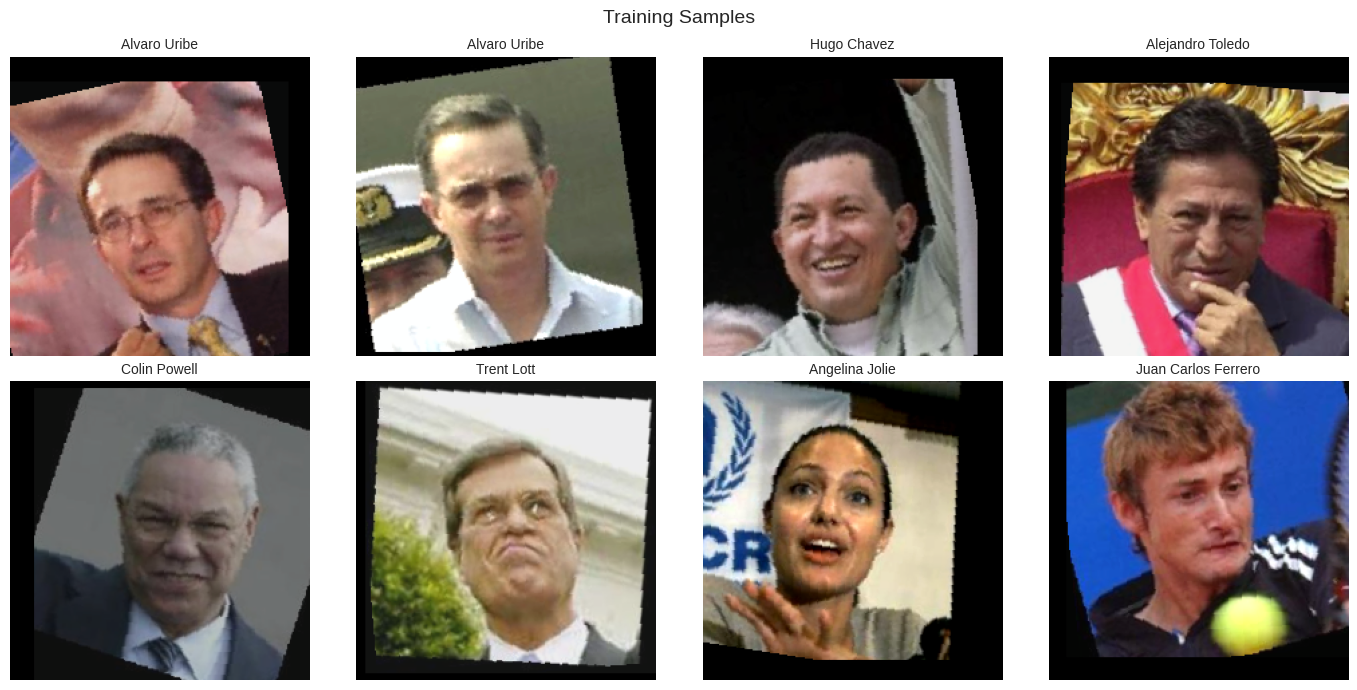

In [8]:
# Visualize samples
def show_samples(dataset, class_names, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    indices = np.random.choice(len(dataset), n, replace=False)
    
    for i, ax in enumerate(axes.flat):
        img, label = dataset[indices[i]]
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        ax.set_title(class_names[label].replace('_', ' '), fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Training Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, class_names)

## 2. Model Architectures

In [9]:
# ============================================================
# VGG16 BACKBONE WRAPPER (Required for proper feature extraction)
# ============================================================
class VGG16Backbone(nn.Module):
    """VGG16 backbone wrapper for proper feature extraction."""
    def __init__(self, pretrained=True):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        self.features = vgg.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        return x

In [10]:
# ============================================================
# BACKBONE DEFINITIONS - PART 2
# ConvNeXt Tiny, VGG16, ResNet101, EfficientNet-B3
# ============================================================

def get_backbone(name, pretrained=True):
    """Get backbone network with pretrained weights."""
    if name == 'convnext_tiny':
        model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[2].in_features
        # Keep LayerNorm2d and Flatten, only remove the Linear layer
        model.classifier = nn.Sequential(
            model.classifier[0],  # LayerNorm2d
            model.classifier[1],  # Flatten
        )
        
    elif name == 'vgg16':
        # VGG16 backbone - using wrapper class
        model = VGG16Backbone(pretrained=pretrained)
        out_features = 512 * 7 * 7  # 25088
        
    elif name == 'resnet101':
        model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2 if pretrained else None)
        out_features = model.fc.in_features
        model.fc = nn.Identity()
        
    elif name == 'efficientnet_b3':
        model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1 if pretrained else None)
        out_features = model.classifier[1].in_features
        model.classifier = nn.Identity()
        
    else:
        raise ValueError(f"Unknown backbone: {name}")
    
    return model, out_features

# Test backbone loading
print("Testing backbone loading...")
for backbone_name in ['vgg16', 'resnet101', 'efficientnet_b3']:
    test_backbone, test_features = get_backbone(backbone_name)
    print(f"  {backbone_name}: {test_features} output features")
    del test_backbone
    
torch.cuda.empty_cache()
gc.collect()

Testing backbone loading...
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 188MB/s]


  vgg16: 25088 output features
Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:00<00:00, 199MB/s]


  resnet101: 2048 output features
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 153MB/s]


  efficientnet_b3: 1536 output features


19172

In [11]:
# ============================================================
# CLASSIFIER HEAD DEFINITIONS - ALL 5 HEADS
# ============================================================

class SimpleHead(nn.Module):
    """Simple linear classifier head."""
    def __init__(self, in_features, num_classes, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class MLPHead(nn.Module):
    """Multi-layer perceptron head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class DeepHead(nn.Module):
    """Deep MLP head with 2 hidden layers."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )
    
    def forward(self, x):
        return self.head(x)

class AttentionHead(nn.Module):
    """Attention-based classifier head."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x):
        # For 1D features, attention simplifies to weighted FC
        return self.fc(x)

class CosFaceHead(nn.Module):
    """CosFace/ArcFace style head with normalized weights."""
    def __init__(self, in_features, num_classes, hidden_dim=512, dropout=0.5, s=30.0, m=0.35):
        super().__init__()
        self.s = s
        self.m = m
        self.projection = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, hidden_dim))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, x, labels=None):
        x = self.projection(x)
        # Normalize features and weights
        x_norm = F.normalize(x, p=2, dim=1)
        w_norm = F.normalize(self.weight, p=2, dim=1)
        # Cosine similarity
        cosine = F.linear(x_norm, w_norm)
        # Scale
        output = self.s * cosine
        return output

# Head factory
def get_head(name, in_features, num_classes, dropout=0.5):
    """Get classifier head by name."""
    heads = {
        'simple': SimpleHead,
        'mlp': MLPHead,
        'deep': DeepHead,
        'attention': AttentionHead,
        'cosface': CosFaceHead
    }
    if name not in heads:
        raise ValueError(f"Unknown head: {name}")
    return heads[name](in_features, num_classes, dropout=dropout)

In [12]:
# ============================================================
# COMPLETE FACE CLASSIFIER MODEL
# ============================================================

class FaceClassifier(nn.Module):
    """Face identification model with configurable backbone and head."""
    
    def __init__(self, num_classes, backbone_name='resnet50', head_name='mlp', 
                 pretrained=True, dropout=0.5):
        super().__init__()
        self.backbone_name = backbone_name
        self.head_name = head_name
        self.num_classes = num_classes
        
        # Load backbone
        self.backbone, out_features = get_backbone(backbone_name, pretrained)
        
        # Create classifier head
        self.head = get_head(head_name, out_features, num_classes, dropout)
    
    def forward(self, x):
        features = self.backbone(x)
        if isinstance(features, tuple):
            features = features[0]
        return self.head(features)
    
    def predict(self, x):
        """Get predictions and probabilities."""
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            probs = F.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
        return preds, probs

# Test model creation
test_model = FaceClassifier(num_classes=100, backbone_name='convnext_tiny', head_name='mlp')
print(f"Model parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model
gc.collect()

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:00<00:00, 222MB/s]


Model parameters: 28,266,180


10

## 3. Training Functions

In [13]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100.0 * correct / total


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100.0 * correct / total
    
    # Calculate additional metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    top5_acc = top_k_accuracy_score(all_labels, all_probs, k=min(5, all_probs.shape[1])) * 100
    
    # Calculate AUC
    try:
        y_true_bin = label_binarize(all_labels, classes=list(range(all_probs.shape[1])))
        if y_true_bin.shape[1] > 1:
            auc_score = roc_auc_score(y_true_bin, all_probs, multi_class='ovr', average='weighted')
        else:
            auc_score = 0.0
    except:
        auc_score = 0.0
    
    return total_loss / len(loader), accuracy, f1, top5_acc, auc_score

In [14]:
def plot_training_curves(history, model_name, save_dir):
    """Plot and save training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy curves
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_curves.png'), dpi=150)
    plt.show()
    plt.close()

In [15]:
def train_model(backbone_name, head_name, train_loader, val_loader, 
                num_classes, epochs=10, lr=1e-4, device='cuda'):
    """Train a single model configuration."""
    model_name = f"{backbone_name}_{head_name}"
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"Epochs: {epochs}")
    print(f"{'='*60}")
    
    # Create model
    model = FaceClassifier(
        num_classes=num_classes,
        backbone_name=backbone_name,
        head_name=head_name,
        pretrained=True,
        dropout=0.5
    )
    
    # Multi-GPU support with DataParallel
    if n_gpus > 1:
        print(f"  Using DataParallel with {n_gpus} GPUs")
        model = nn.DataParallel(model)
    model = model.to(device)
    
    # Training setup
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=lr/100)
    scaler = GradScaler()
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_f1': [], 'val_top5': [], 'val_auc': []
    }
    
    best_acc = 0
    best_model_state = None
    
    # Training loop - 10 EPOCHS
    start_time = time.time()
    pbar = tqdm(range(epochs), desc=f"Training {model_name}")
    for epoch in pbar:
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
        
        # Validate
        val_loss, val_acc, val_f1, val_top5, val_auc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_top5'].append(val_top5)
        history['val_auc'].append(val_auc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_to_save = model.module if hasattr(model, 'module') else model
            best_model_state = {k: v.cpu().clone() for k, v in model_to_save.state_dict().items()}
        
        pbar.set_postfix({
            'loss': f"{train_loss:.4f}",
            'acc': f"{train_acc:.1f}%",
            'val_acc': f"{val_acc:.1f}%",
            'top5': f"{val_top5:.1f}%"
        })
    
    training_time = time.time() - start_time
    
    # Plot training curves
    plot_training_curves(history, model_name, WORK_DIR)
    
    # Final results
    results = {
        'model_name': model_name,
        'backbone': backbone_name,
        'head': head_name,
        'best_val_acc': best_acc,
        'final_val_acc': history['val_acc'][-1],
        'final_val_f1': history['val_f1'][-1],
        'final_val_top5': history['val_top5'][-1],
        'final_val_auc': history['val_auc'][-1],
        'final_train_acc': history['train_acc'][-1],
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'training_time': training_time,
        'history': history
    }
    
    print(f"\n  Best Val Accuracy: {best_acc:.2f}%")
    print(f"  Final Top-5 Accuracy: {val_top5:.2f}%")
    print(f"  Final F1 Score: {val_f1:.4f}")
    print(f"  Final AUC-ROC: {val_auc:.4f}")
    print(f"  Training Time: {training_time/60:.1f} min")
    
    # MEMORY CLEANUP - CRITICAL FOR OOM PREVENTION
    del model
    del optimizer
    del scaler
    del criterion
    torch.cuda.empty_cache()
    gc.collect()
    
    return results, best_model_state

## 4. Train All Models (Neural + Classical)

In [16]:
# ============================================================
# MODEL CONFIGURATIONS - PART 2
# ============================================================

# Part 2 backbones
BACKBONES = ['vgg16', 'resnet101', 'efficientnet_b3']

# Neural network classifier heads - ALL 5
NEURAL_HEADS = ['simple', 'mlp', 'deep', 'attention', 'cosface']

# Classical ML classifiers - ALL 4
CLASSICAL_CLASSIFIERS = {
    'svm_rbf': lambda: SVC(kernel='rbf', probability=True, random_state=SEED, C=1.0, gamma='scale'),
    'svm_linear': lambda: SVC(kernel='linear', probability=True, random_state=SEED, C=1.0),
    'random_forest': lambda: RandomForestClassifier(n_estimators=200, max_depth=20, random_state=SEED, n_jobs=-1),
}

# Add XGBoost if available
if HAS_XGB:
    CLASSICAL_CLASSIFIERS['xgboost'] = lambda: xgb.XGBClassifier(
        n_estimators=200, 
        max_depth=6, 
        learning_rate=0.1, 
        random_state=SEED, 
        eval_metric='mlogloss',
        use_label_encoder=False
    )

# Training hyperparameters - 10 EPOCHS
EPOCHS = 10
LEARNING_RATE = 1e-4

# Calculate total models
total_neural = len(BACKBONES) * len(NEURAL_HEADS)
total_classical = len(BACKBONES) * len(CLASSICAL_CLASSIFIERS)
total_models = total_neural + total_classical

print(f"\n{'='*60}")
print("PART 2 - MODEL CONFIGURATIONS")
print(f"{'='*60}")
print(f"\nBackbones ({len(BACKBONES)}): {BACKBONES}")
print(f"\nNeural Heads ({len(NEURAL_HEADS)}): {NEURAL_HEADS}")
print(f"Classical Classifiers ({len(CLASSICAL_CLASSIFIERS)}): {list(CLASSICAL_CLASSIFIERS.keys())}")
print(f"\nTotal Neural Network models: {len(BACKBONES)} × {len(NEURAL_HEADS)} = {total_neural}")
print(f"Total Classical ML models: {len(BACKBONES)} × {len(CLASSICAL_CLASSIFIERS)} = {total_classical}")
print(f"TOTAL MODELS: {total_models}")
print(f"\nEpochs for neural models: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"{'='*60}")


PART 2 - MODEL CONFIGURATIONS

Backbones (3): ['vgg16', 'resnet101', 'efficientnet_b3']

Neural Heads (5): ['simple', 'mlp', 'deep', 'attention', 'cosface']
Classical Classifiers (4): ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost']

Total Neural Network models: 3 × 5 = 15
Total Classical ML models: 3 × 4 = 12
TOTAL MODELS: 27

Epochs for neural models: 10
Learning rate: 0.0001



[1/15] Training vgg16 + simple

Training: vgg16_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training vgg16_simple:   0%|          | 0/10 [00:00<?, ?it/s]

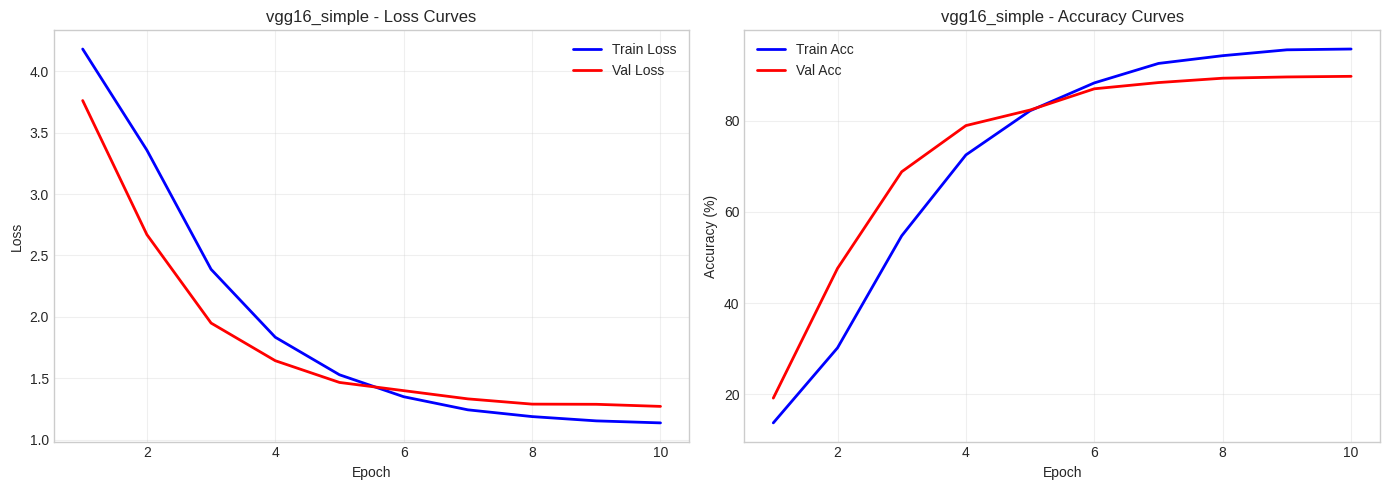


  Best Val Accuracy: 89.74%
  Final Top-5 Accuracy: 97.67%
  Final F1 Score: 0.8933
  Final AUC-ROC: 0.9986
  Training Time: 14.3 min
  Saved to /kaggle/working/models_part2/vgg16_simple_run1.pt

[2/15] Training vgg16 + mlp

Training: vgg16_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training vgg16_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

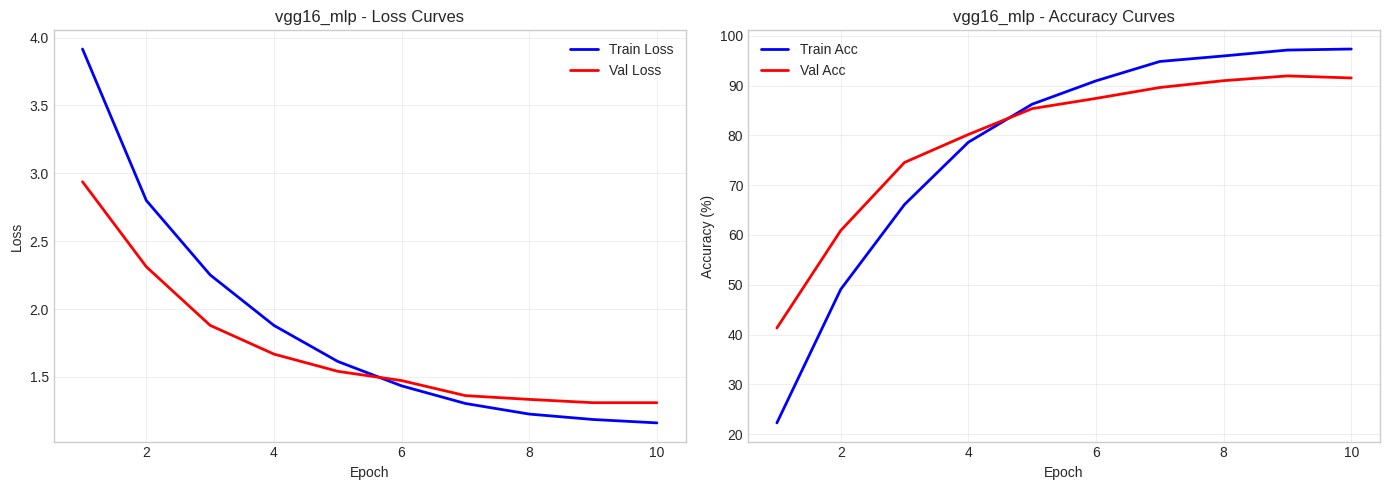


  Best Val Accuracy: 91.93%
  Final Top-5 Accuracy: 97.40%
  Final F1 Score: 0.9109
  Final AUC-ROC: 0.9987
  Training Time: 14.3 min
  Saved to /kaggle/working/models_part2/vgg16_mlp_run1.pt

[3/15] Training vgg16 + deep

Training: vgg16_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training vgg16_deep:   0%|          | 0/10 [00:00<?, ?it/s]

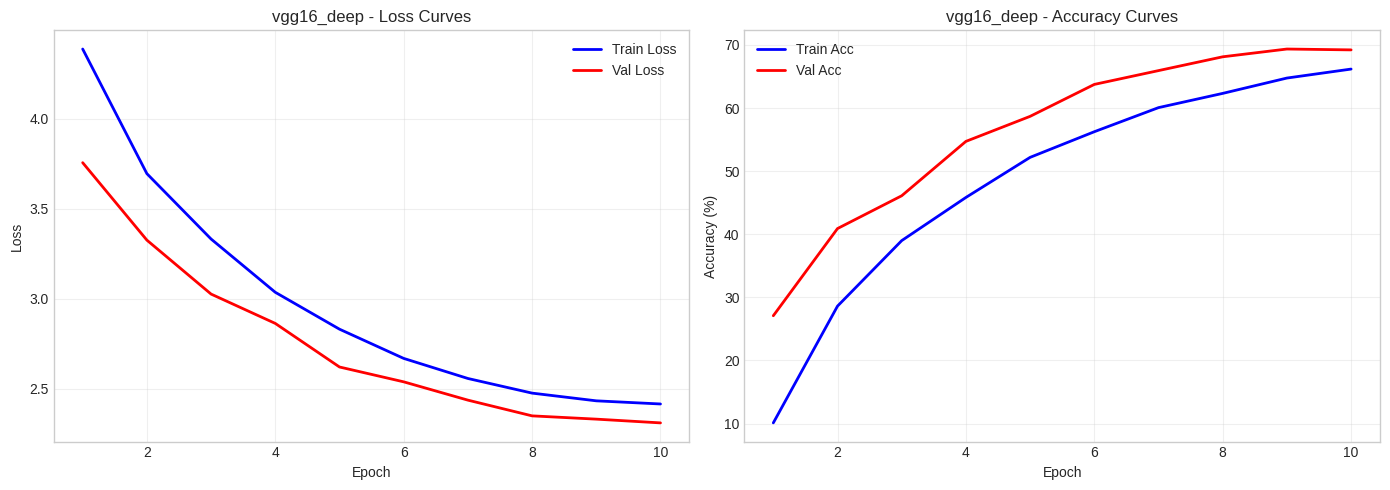


  Best Val Accuracy: 69.36%
  Final Top-5 Accuracy: 86.05%
  Final F1 Score: 0.6160
  Final AUC-ROC: 0.9941
  Training Time: 14.3 min
  Saved to /kaggle/working/models_part2/vgg16_deep_run1.pt

[4/15] Training vgg16 + attention

Training: vgg16_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training vgg16_attention:   0%|          | 0/10 [00:00<?, ?it/s]

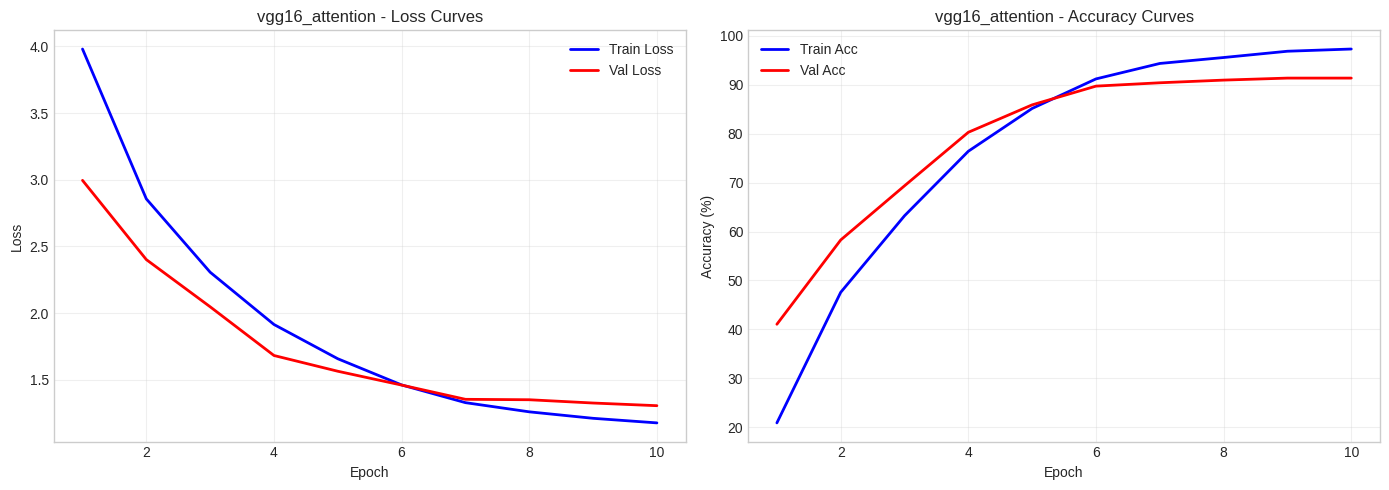


  Best Val Accuracy: 91.38%
  Final Top-5 Accuracy: 97.26%
  Final F1 Score: 0.9081
  Final AUC-ROC: 0.9991
  Training Time: 14.4 min
  Saved to /kaggle/working/models_part2/vgg16_attention_run1.pt

[5/15] Training vgg16 + cosface

Training: vgg16_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training vgg16_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

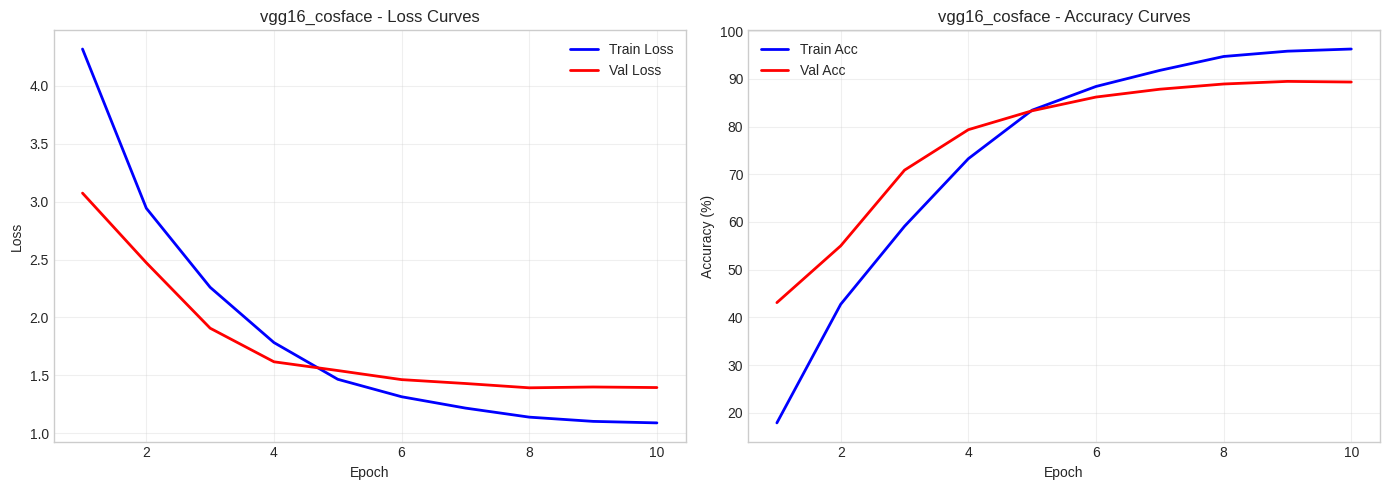


  Best Val Accuracy: 89.47%
  Final Top-5 Accuracy: 96.31%
  Final F1 Score: 0.8868
  Final AUC-ROC: 0.9978
  Training Time: 14.3 min
  Saved to /kaggle/working/models_part2/vgg16_cosface_run1.pt

[6/15] Training resnet101 + simple

Training: resnet101_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet101_simple:   0%|          | 0/10 [00:00<?, ?it/s]

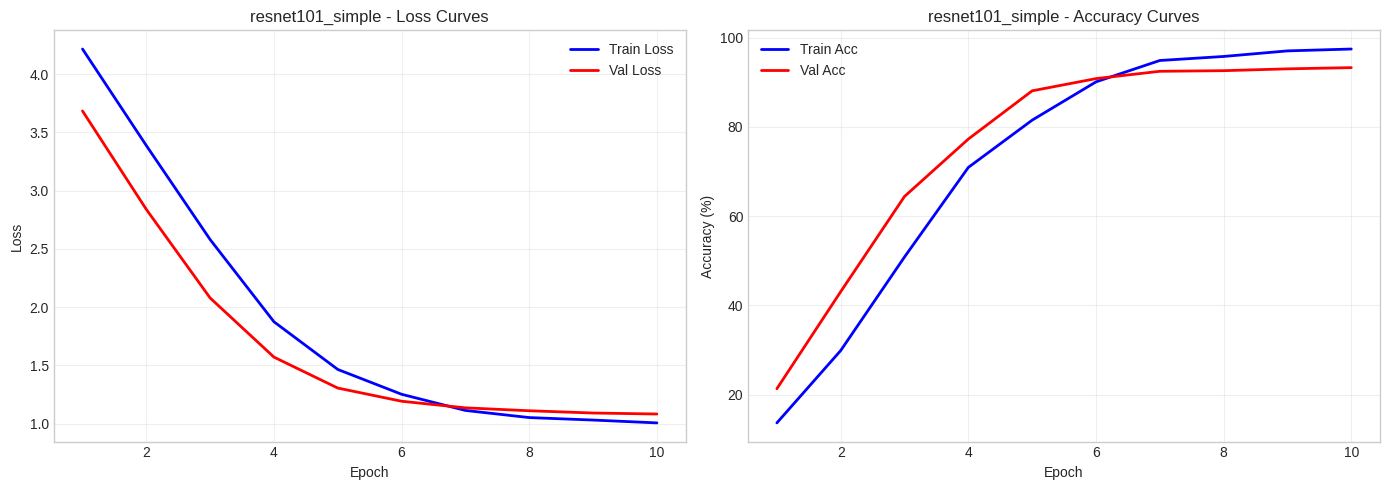


  Best Val Accuracy: 93.30%
  Final Top-5 Accuracy: 97.81%
  Final F1 Score: 0.9304
  Final AUC-ROC: 0.9991
  Training Time: 8.1 min
  Saved to /kaggle/working/models_part2/resnet101_simple_run1.pt

[7/15] Training resnet101 + mlp

Training: resnet101_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet101_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

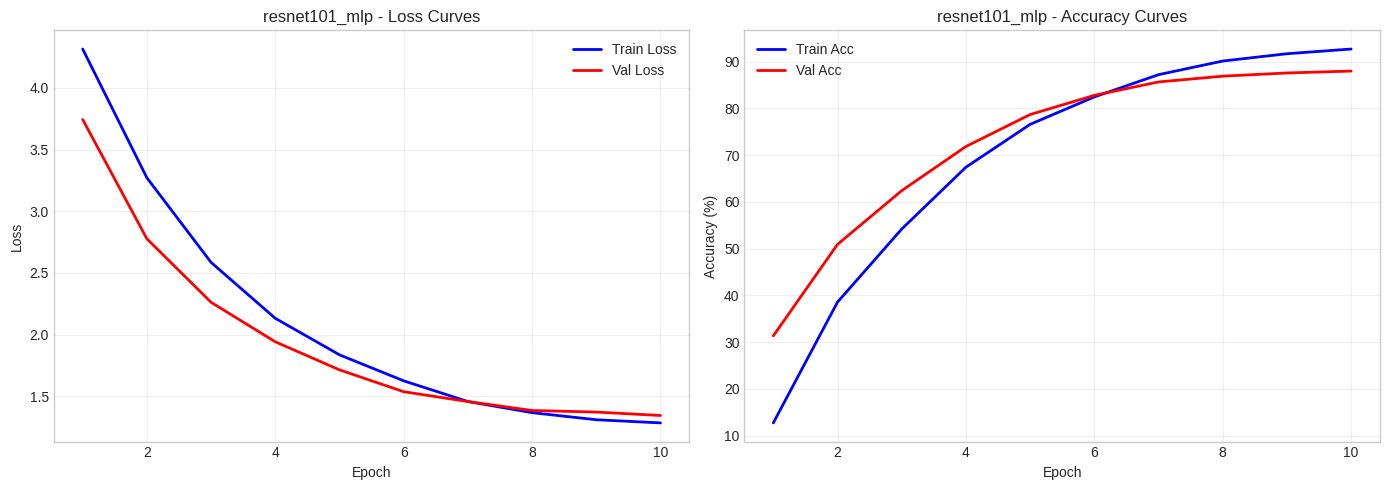


  Best Val Accuracy: 87.96%
  Final Top-5 Accuracy: 96.17%
  Final F1 Score: 0.8602
  Final AUC-ROC: 0.9984
  Training Time: 8.0 min
  Saved to /kaggle/working/models_part2/resnet101_mlp_run1.pt

[8/15] Training resnet101 + deep

Training: resnet101_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet101_deep:   0%|          | 0/10 [00:00<?, ?it/s]

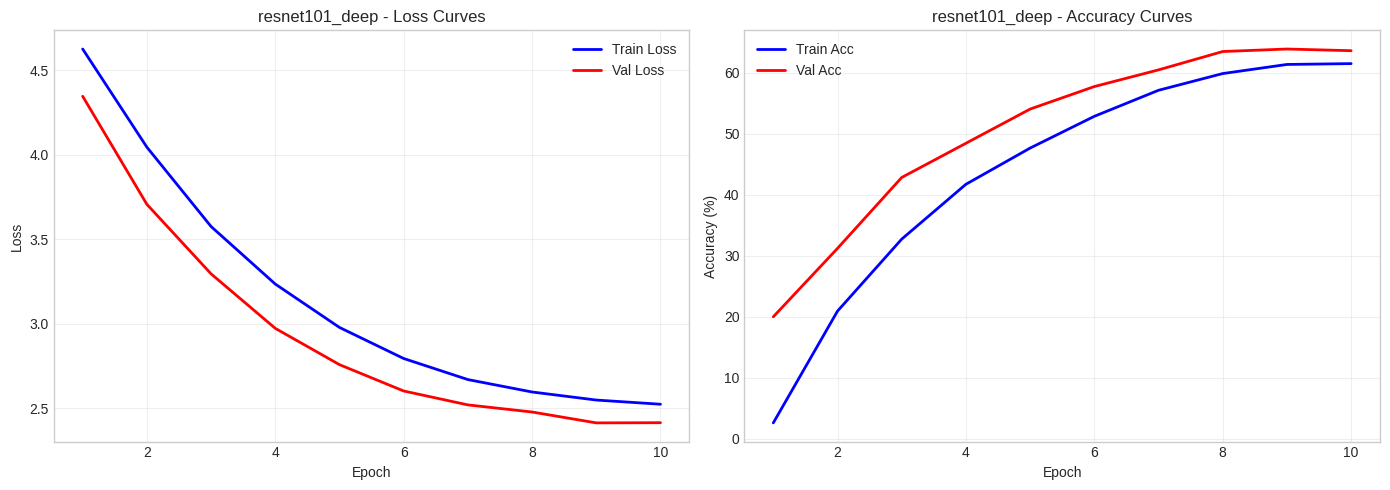


  Best Val Accuracy: 63.89%
  Final Top-5 Accuracy: 81.81%
  Final F1 Score: 0.5513
  Final AUC-ROC: 0.9901
  Training Time: 8.0 min
  Saved to /kaggle/working/models_part2/resnet101_deep_run1.pt

[9/15] Training resnet101 + attention

Training: resnet101_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet101_attention:   0%|          | 0/10 [00:00<?, ?it/s]

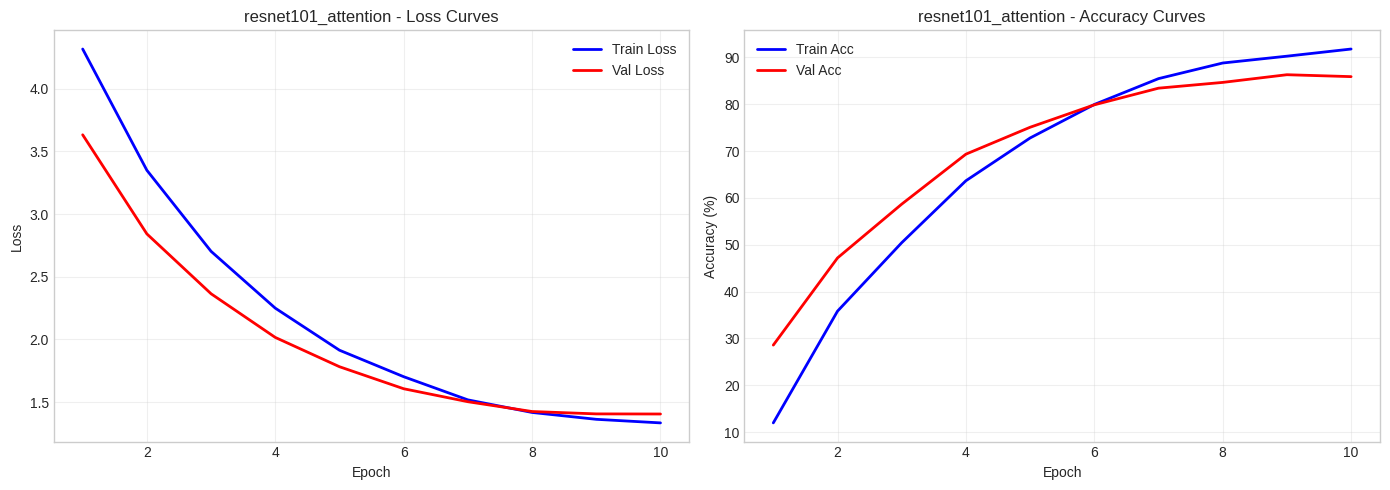


  Best Val Accuracy: 86.32%
  Final Top-5 Accuracy: 96.99%
  Final F1 Score: 0.8405
  Final AUC-ROC: 0.9983
  Training Time: 8.0 min
  Saved to /kaggle/working/models_part2/resnet101_attention_run1.pt

[10/15] Training resnet101 + cosface

Training: resnet101_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training resnet101_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

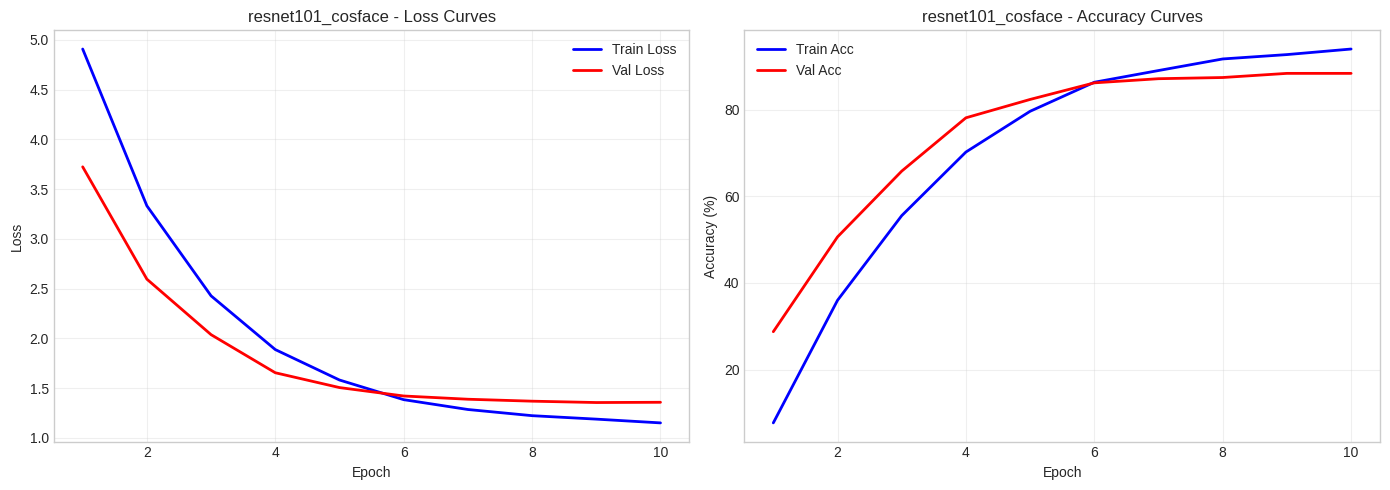


  Best Val Accuracy: 88.37%
  Final Top-5 Accuracy: 97.81%
  Final F1 Score: 0.8754
  Final AUC-ROC: 0.9984
  Training Time: 8.0 min
  Saved to /kaggle/working/models_part2/resnet101_cosface_run1.pt

[11/15] Training efficientnet_b3 + simple

Training: efficientnet_b3_simple
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b3_simple:   0%|          | 0/10 [00:00<?, ?it/s]

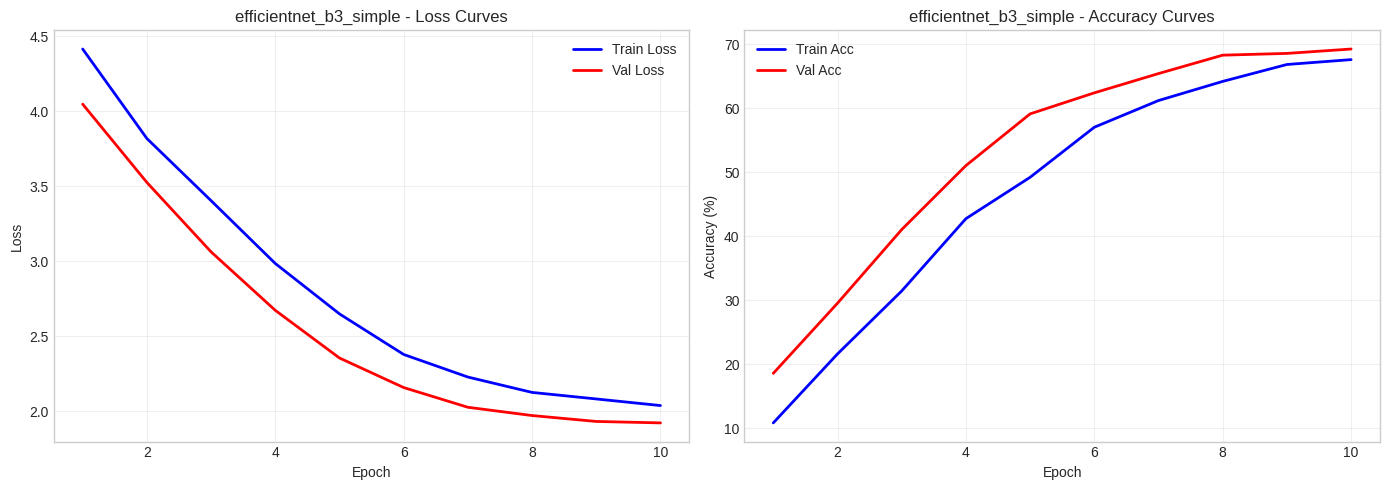


  Best Val Accuracy: 69.22%
  Final Top-5 Accuracy: 89.33%
  Final F1 Score: 0.6250
  Final AUC-ROC: 0.9949
  Training Time: 62.1 min
  Saved to /kaggle/working/models_part2/efficientnet_b3_simple_run1.pt

[12/15] Training efficientnet_b3 + mlp

Training: efficientnet_b3_mlp
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b3_mlp:   0%|          | 0/10 [00:00<?, ?it/s]

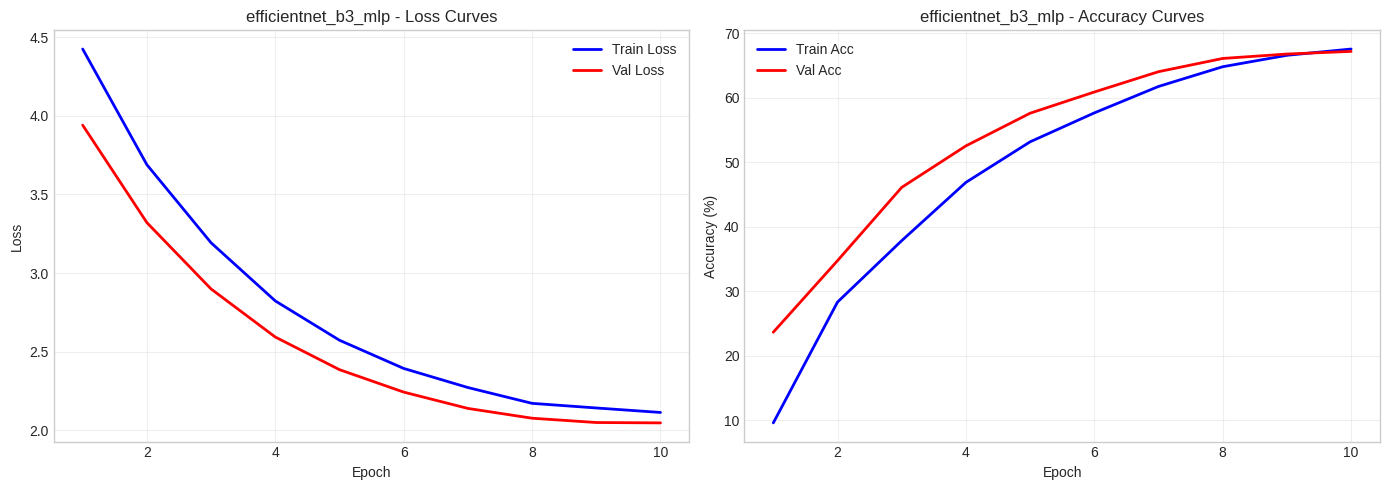


  Best Val Accuracy: 67.17%
  Final Top-5 Accuracy: 89.88%
  Final F1 Score: 0.5934
  Final AUC-ROC: 0.9944
  Training Time: 61.0 min
  Saved to /kaggle/working/models_part2/efficientnet_b3_mlp_run1.pt

[13/15] Training efficientnet_b3 + deep

Training: efficientnet_b3_deep
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b3_deep:   0%|          | 0/10 [00:00<?, ?it/s]

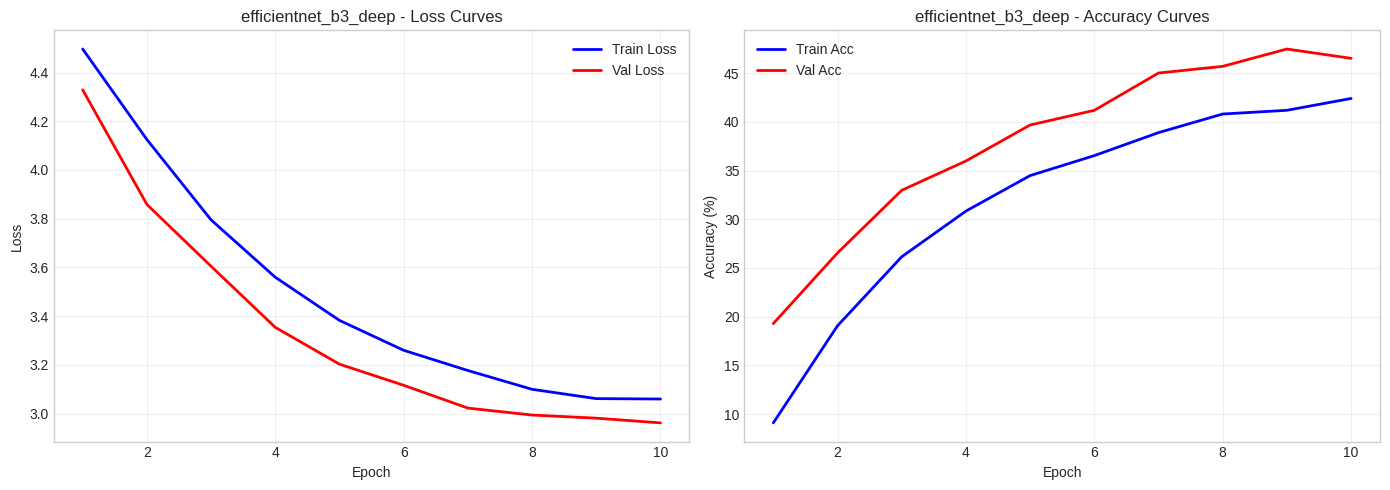


  Best Val Accuracy: 47.47%
  Final Top-5 Accuracy: 69.49%
  Final F1 Score: 0.3417
  Final AUC-ROC: 0.9724
  Training Time: 60.1 min
  Saved to /kaggle/working/models_part2/efficientnet_b3_deep_run1.pt

[14/15] Training efficientnet_b3 + attention

Training: efficientnet_b3_attention
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b3_attention:   0%|          | 0/10 [00:00<?, ?it/s]

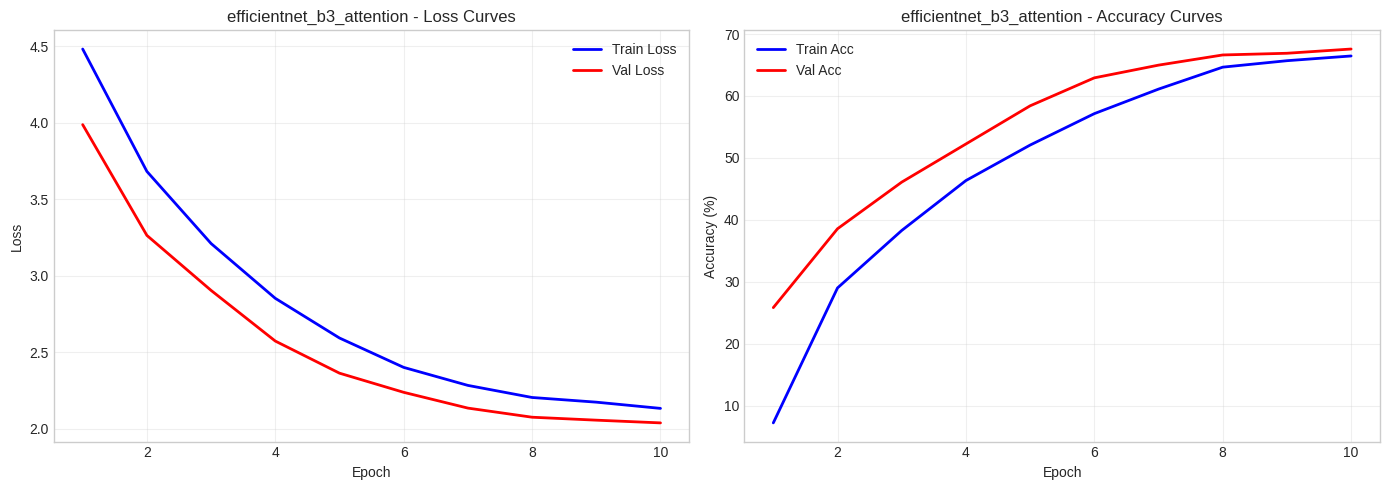


  Best Val Accuracy: 67.58%
  Final Top-5 Accuracy: 88.24%
  Final F1 Score: 0.5960
  Final AUC-ROC: 0.9951
  Training Time: 60.4 min
  Saved to /kaggle/working/models_part2/efficientnet_b3_attention_run1.pt

[15/15] Training efficientnet_b3 + cosface

Training: efficientnet_b3_cosface
Epochs: 10
  Using DataParallel with 2 GPUs


Training efficientnet_b3_cosface:   0%|          | 0/10 [00:00<?, ?it/s]

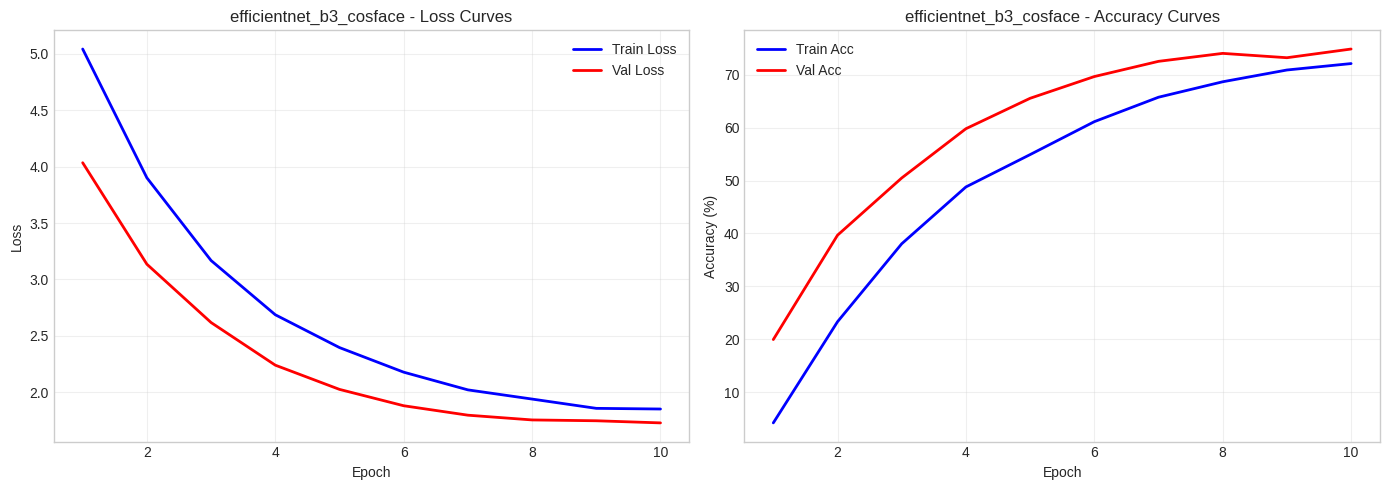


  Best Val Accuracy: 74.83%
  Final Top-5 Accuracy: 90.83%
  Final F1 Score: 0.7057
  Final AUC-ROC: 0.9934
  Training Time: 60.5 min
  Saved to /kaggle/working/models_part2/efficientnet_b3_cosface_run1.pt

Neural Network Training complete! 15 models trained.


In [17]:
# ============================================================
# TRAIN ALL NEURAL NETWORK MODELS (Backbone + Neural Head)
# ============================================================

all_results = {}
all_model_states = {}
backbone_features = {}  # Store extracted features for classical classifiers

current_model = 0

for backbone_name in BACKBONES:
    for head_name in NEURAL_HEADS:
        current_model += 1
        model_key = f"{backbone_name}_{head_name}"
        print(f"\n[{current_model}/{total_neural}] Training {backbone_name} + {head_name}")
        
        try:
            results, model_state = train_model(
                backbone_name=backbone_name,
                head_name=head_name,
                train_loader=train_loader,
                val_loader=val_loader,
                num_classes=num_classes,
                epochs=EPOCHS,  # 10 EPOCHS
                lr=LEARNING_RATE,
                device=device
            )
            
            all_results[model_key] = results
            all_model_states[model_key] = model_state
            
            # Save individual model with systematic naming
            save_path = os.path.join(MODELS_DIR, f"{model_key}_run1.pt")
            torch.save({
                'model_state_dict': model_state,
                'backbone': backbone_name,
                'head': head_name,
                'num_classes': num_classes,
                'class_names': class_names,
                'results': results
            }, save_path)
            print(f"  Saved to {save_path}")
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            import traceback
            traceback.print_exc()
            # Memory cleanup on error
            torch.cuda.empty_cache()
            gc.collect()
            continue

print(f"\n{'='*60}")
print(f"Neural Network Training complete! {len(all_results)} models trained.")
print(f"{'='*60}")

## 4.1 Extract Features for Classical Classifiers

In [18]:
# ============================================================
# FEATURE EXTRACTION FOR CLASSICAL CLASSIFIERS
# Extract embeddings from trained backbones for SVM, RF, XGBoost
# ============================================================

def extract_features_from_backbone(backbone_name, train_loader, val_loader, device):
    """Extract features using a trained or pretrained backbone."""
    print(f"\nExtracting features from {backbone_name}...")
    
    # Create backbone model
    backbone, out_features = get_backbone(backbone_name, pretrained=True)
    backbone = backbone.to(device)
    backbone.eval()
    
    if n_gpus > 1:
        backbone = nn.DataParallel(backbone)
    
    train_features = []
    train_labels = []
    val_features = []
    val_labels = []
    
    # Extract training features
    with torch.no_grad():
        for images, labels in tqdm(train_loader, desc=f"  Train features"):
            images = images.to(device, non_blocking=True)
            with autocast(device_type='cuda'):
                features = backbone(images)
                if isinstance(features, tuple):
                    features = features[0]
                # Flatten if needed
                if features.dim() > 2:
                    features = features.view(features.size(0), -1)
            train_features.append(features.cpu().numpy())
            train_labels.extend(labels.numpy())
    
    # Extract validation features
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"  Val features"):
            images = images.to(device, non_blocking=True)
            with autocast(device_type='cuda'):
                features = backbone(images)
                if isinstance(features, tuple):
                    features = features[0]
                if features.dim() > 2:
                    features = features.view(features.size(0), -1)
            val_features.append(features.cpu().numpy())
            val_labels.extend(labels.numpy())
    
    X_train = np.vstack(train_features)
    y_train = np.array(train_labels)
    X_val = np.vstack(val_features)
    y_val = np.array(val_labels)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Save scaler
    scaler_path = os.path.join(MODELS_DIR, f'{backbone_name}_scaler.joblib')
    joblib.dump(scaler, scaler_path)
    
    # Memory cleanup
    del backbone
    torch.cuda.empty_cache()
    gc.collect()
    
    print(f"  Features shape: Train {X_train_scaled.shape}, Val {X_val_scaled.shape}")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'scaler_path': scaler_path
    }

# Extract features from all backbones
print(f"\n{'='*60}")
print("EXTRACTING FEATURES FOR CLASSICAL CLASSIFIERS")
print(f"{'='*60}")

for backbone_name in BACKBONES:
    backbone_features[backbone_name] = extract_features_from_backbone(
        backbone_name, train_loader, val_loader, device
    )

print(f"\n{'='*60}")
print("Feature extraction complete!")
print(f"{'='*60}")


EXTRACTING FEATURES FOR CLASSICAL CLASSIFIERS

Extracting features from vgg16...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e623cf0c7c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


  Features shape: Train (2880, 25088), Val (731, 25088)

Extracting features from resnet101...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 2048), Val (731, 2048)

Extracting features from efficientnet_b3...


  Train features:   0%|          | 0/45 [00:00<?, ?it/s]

  Val features:   0%|          | 0/12 [00:00<?, ?it/s]

  Features shape: Train (2880, 1536), Val (731, 1536)

Feature extraction complete!


## 4.2 Train Classical Classifiers (SVM, Random Forest, XGBoost)

In [19]:
# ============================================================
# TRAIN CLASSICAL CLASSIFIERS ON EXTRACTED FEATURES
# SVM (RBF & Linear), Random Forest, XGBoost
# ============================================================

def train_classical_classifier(clf_name, clf_fn, X_train, y_train, X_val, y_val, num_classes):
    """Train and evaluate a classical classifier."""
    print(f"  Training {clf_name}...", end=" ")
    start_time = time.time()
    
    try:
        clf = clf_fn()
        clf.fit(X_train, y_train)
        
        # Training metrics
        train_preds = clf.predict(X_train)
        train_probs = clf.predict_proba(X_train)
        train_acc = accuracy_score(y_train, train_preds) * 100
        
        # Validation metrics
        val_preds = clf.predict(X_val)
        val_probs = clf.predict_proba(X_val)
        val_acc = accuracy_score(y_val, val_preds) * 100
        val_f1 = f1_score(y_val, val_preds, average='weighted')
        val_precision = precision_score(y_val, val_preds, average='weighted')
        val_recall = recall_score(y_val, val_preds, average='weighted')
        
        # Top-5 accuracy
        top5_acc = top_k_accuracy_score(y_val, val_probs, k=min(5, val_probs.shape[1])) * 100
        
        # AUC-ROC
        try:
            y_val_bin = label_binarize(y_val, classes=list(range(num_classes)))
            if y_val_bin.shape[1] > 1:
                auc_score = roc_auc_score(y_val_bin, val_probs, multi_class='ovr', average='weighted')
            else:
                auc_score = 0.0
        except:
            auc_score = 0.0
        
        elapsed = time.time() - start_time
        print(f"Done in {elapsed:.1f}s | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | AUC: {auc_score:.4f}")
        
        return {
            'train_acc': train_acc,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'top5_acc': top5_acc,
            'auc_score': auc_score,
            'train_time': elapsed
        }, clf, val_preds, val_probs
        
    except Exception as e:
        print(f"ERROR: {e}")
        return None, None, None, None

# Store classical classifier results
classical_results = {}
trained_classifiers = {}

current_model = 0

print(f"\n{'='*60}")
print("TRAINING CLASSICAL CLASSIFIERS")
print(f"{'='*60}")

for backbone_name in BACKBONES:
    print(f"\n--- {backbone_name.upper()} Features ---")
    
    feat = backbone_features[backbone_name]
    X_train_feat = feat['X_train']
    X_val_feat = feat['X_val']
    y_train_feat = feat['y_train']
    y_val_feat = feat['y_val']
    
    for clf_name, clf_fn in CLASSICAL_CLASSIFIERS.items():
        current_model += 1
        model_key = f"{backbone_name}_{clf_name}"
        
        metrics, clf, val_preds, val_probs = train_classical_classifier(
            clf_name, clf_fn, X_train_feat, y_train_feat, X_val_feat, y_val_feat, num_classes
        )
        
        if metrics is not None:
            # Store results in same format as neural models
            classical_results[model_key] = {
                'model_name': model_key,
                'backbone': backbone_name,
                'head': clf_name,
                'best_val_acc': metrics['val_acc'],
                'final_val_acc': metrics['val_acc'],
                'final_val_f1': metrics['val_f1'],
                'final_val_top5': metrics['top5_acc'],
                'final_val_auc': metrics['auc_score'],
                'final_train_acc': metrics['train_acc'],
                'val_precision': metrics['val_precision'],
                'val_recall': metrics['val_recall'],
                'train_time': metrics['train_time'],
                'classifier_type': 'classical',
                'history': {
                    'train_loss': [],
                    'train_acc': [metrics['train_acc']],
                    'val_loss': [],
                    'val_acc': [metrics['val_acc']]
                }
            }
            
            trained_classifiers[model_key] = clf
            
            # Save classifier with systematic naming
            clf_path = os.path.join(MODELS_DIR, f"{model_key}_run1.joblib")
            joblib.dump({
                'classifier': clf,
                'backbone': backbone_name,
                'classifier_type': clf_name,
                'num_classes': num_classes,
                'class_names': class_names,
                'scaler_path': feat['scaler_path'],
                'metrics': metrics
            }, clf_path)
        
        # Memory cleanup
        gc.collect()

print(f"\n{'='*60}")
print(f"Classical Classifier Training complete! {len(classical_results)} models trained.")
print(f"{'='*60}")


TRAINING CLASSICAL CLASSIFIERS

--- VGG16 Features ---
  Training svm_rbf... Done in 2331.2s | Train: 60.3% | Val: 16.4% | AUC: 0.7946
  Training svm_linear... Done in 1130.8s | Train: 100.0% | Val: 31.1% | AUC: 0.8993
  Training random_forest... Done in 19.2s | Train: 100.0% | Val: 18.3% | AUC: 0.8497
  Training xgboost... Done in 8888.2s | Train: 100.0% | Val: 40.5% | AUC: 0.9222

--- RESNET101 Features ---
  Training svm_rbf... Done in 135.4s | Train: 67.4% | Val: 24.4% | AUC: 0.8901
  Training svm_linear... Done in 81.1s | Train: 100.0% | Val: 47.5% | AUC: 0.9269
  Training random_forest... Done in 14.5s | Train: 100.0% | Val: 29.4% | AUC: 0.8918
  Training xgboost... Done in 817.7s | Train: 100.0% | Val: 47.5% | AUC: 0.9316

--- EFFICIENTNET_B3 Features ---
  Training svm_rbf... Done in 90.1s | Train: 70.3% | Val: 35.2% | AUC: 0.9300
  Training svm_linear... Done in 51.0s | Train: 100.0% | Val: 55.8% | AUC: 0.9541
  Training random_forest... Done in 21.6s | Train: 100.0% | Val: 3

In [20]:
# ============================================================
# MERGE ALL RESULTS (Neural + Classical)
# ============================================================

# Combine neural network and classical classifier results
all_results.update(classical_results)

print(f"\n{'='*60}")
print("ALL MODELS SUMMARY")
print(f"{'='*60}")
print(f"Neural Network Models: {len(all_results) - len(classical_results)}")
print(f"Classical ML Models:   {len(classical_results)}")
print(f"Total Models:          {len(all_results)}")
print(f"{'='*60}")


ALL MODELS SUMMARY
Neural Network Models: 15
Classical ML Models:   12
Total Models:          27


## 5. Results Analysis

In [21]:
# Create results DataFrame (including both neural and classical models)
results_data = []
for name, res in all_results.items():
    results_data.append({
        'Model': name,
        'Backbone': res.get('backbone', 'unknown'),
        'Head': res.get('head', 'unknown'),
        'Type': 'Classical' if res.get('classifier_type') == 'classical' else 'Neural',
        'Train Acc': res.get('final_train_acc', 0),
        'Val Acc': res.get('final_val_acc', 0),
        'Best Val Acc': res.get('best_val_acc', 0),
        'Val F1': res.get('final_val_f1', 0),
        'Top-5 Acc': res.get('final_val_top5', 0),
        'AUC-ROC': res.get('final_val_auc', 0)
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('Best Val Acc', ascending=False)

print("\n" + "="*80)
print("PART 2 - ALL MODELS RANKED BY VALIDATION ACCURACY")
print("="*80)
display(results_df.style.highlight_max(subset=['Train Acc', 'Val Acc', 'Best Val Acc', 'Val F1', 'Top-5 Acc', 'AUC-ROC'])
        .format(precision=2))


PART 2 - ALL MODELS RANKED BY VALIDATION ACCURACY


,Model,Backbone,Head,Type,Train Acc,Val Acc,Best Val Acc,Val F1,Top-5 Acc,AUC-ROC
5,resnet101_simple,resnet101,simple,Neural,97.47,93.30,93.30,0.93,97.81,1.00
1,vgg16_mlp,vgg16,mlp,Neural,97.33,91.52,91.93,0.91,97.40,1.00
3,vgg16_attention,vgg16,attention,Neural,97.33,91.38,91.38,0.91,97.26,1.00
0,vgg16_simple,vgg16,simple,Neural,95.73,89.74,89.74,0.89,97.67,1.00
4,vgg16_cosface,vgg16,cosface,Neural,96.25,89.33,89.47,0.89,96.31,1.00
9,resnet101_cosface,resnet101,cosface,Neural,93.99,88.37,88.37,0.88,97.81,1.00
6,resnet101_mlp,resnet101,mlp,Neural,92.67,87.96,87.96,0.86,96.17,1.00
8,resnet101_attention,resnet101,attention,Neural,91.81,85.91,86.32,0.84,96.99,1.00
14,efficientnet_b3_cosface,efficientnet_b3,cosface,Neural,72.08,74.83,74.83,0.71,90.83,0.99
2,vgg16_deep,vgg16,deep,Neural,66.18,69.22,69.36,0.62,86.05,0.99


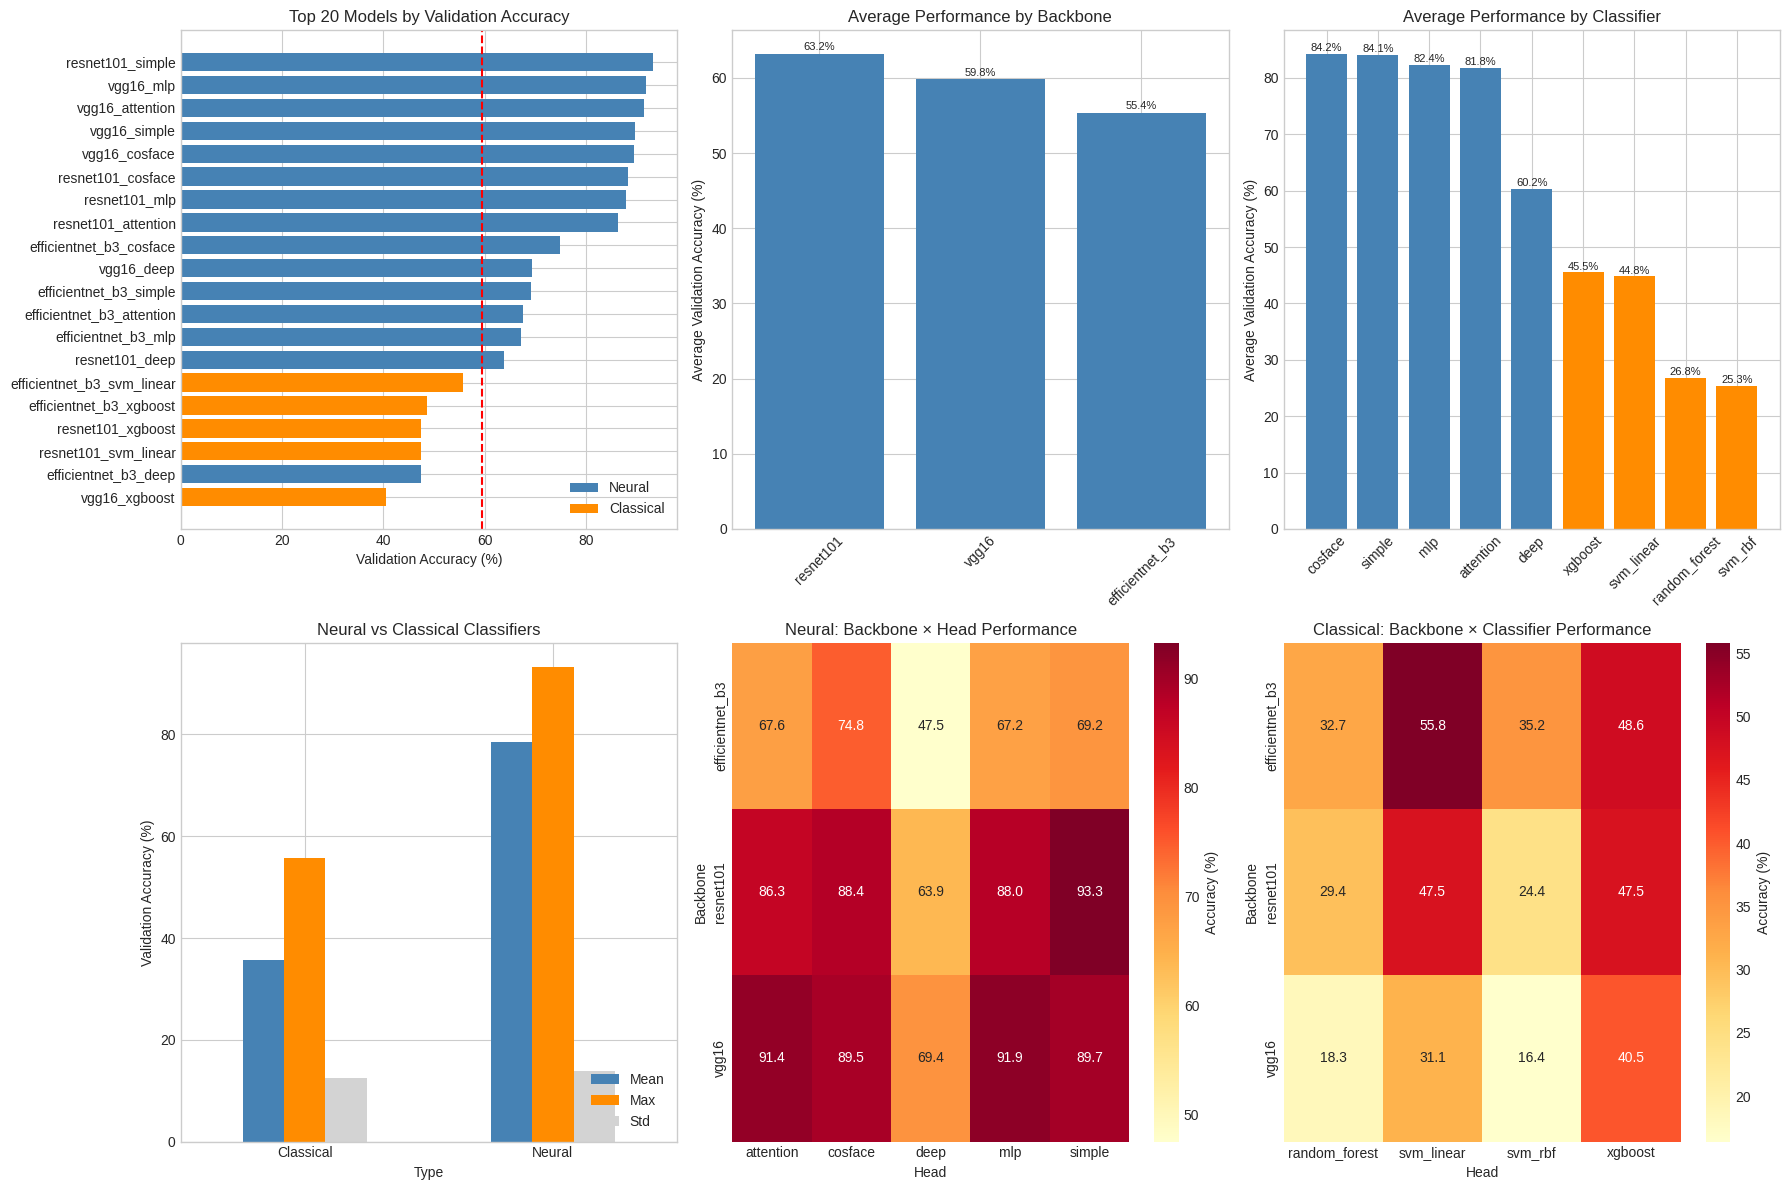

In [22]:
# Visualize results (including classical classifiers)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Validation Accuracy by Model (Top 20)
ax = axes[0, 0]
top_20 = results_df.head(20).sort_values('Best Val Acc', ascending=True)
colors = ['darkorange' if t == 'Classical' else 'steelblue' for t in top_20['Type']]
ax.barh(top_20['Model'], top_20['Best Val Acc'], color=colors)
ax.set_xlabel('Validation Accuracy (%)')
ax.set_title('Top 20 Models by Validation Accuracy')
ax.axvline(results_df['Best Val Acc'].mean(), color='red', linestyle='--', label='Mean')
# Legend for model types
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Neural'),
                   Patch(facecolor='darkorange', label='Classical')]
ax.legend(handles=legend_elements, loc='lower right')

# 2. Backbone Comparison
ax = axes[0, 1]
backbone_avg = results_df.groupby('Backbone')['Best Val Acc'].mean().sort_values(ascending=False)
ax.bar(backbone_avg.index, backbone_avg.values, color='steelblue')
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Backbone')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(backbone_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=8)

# 3. Classifier Head Comparison
ax = axes[0, 2]
head_avg = results_df.groupby('Head')['Best Val Acc'].mean().sort_values(ascending=False)
colors = ['darkorange' if h in ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost'] else 'steelblue' 
          for h in head_avg.index]
ax.bar(head_avg.index, head_avg.values, color=colors)
ax.set_ylabel('Average Validation Accuracy (%)')
ax.set_title('Average Performance by Classifier')
ax.tick_params(axis='x', rotation=45)
for i, v in enumerate(head_avg.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=8)

# 4. Neural vs Classical Comparison
ax = axes[1, 0]
type_comparison = results_df.groupby('Type').agg({
    'Best Val Acc': ['mean', 'max', 'std']
}).round(2)
type_comparison.columns = ['Mean', 'Max', 'Std']
type_comparison.plot(kind='bar', ax=ax, color=['steelblue', 'darkorange', 'lightgray'])
ax.set_title('Neural vs Classical Classifiers')
ax.set_ylabel('Validation Accuracy (%)')
ax.tick_params(axis='x', rotation=0)
ax.legend(loc='lower right')

# 5. Heatmap - Neural Models
ax = axes[1, 1]
neural_df = results_df[results_df['Type'] == 'Neural']
if len(neural_df) > 0:
    pivot_neural = neural_df.pivot(index='Backbone', columns='Head', values='Best Val Acc')
    sns.heatmap(pivot_neural, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax, 
                cbar_kws={'label': 'Accuracy (%)'})
    ax.set_title('Neural: Backbone × Head Performance')
else:
    ax.text(0.5, 0.5, 'No Neural Models', ha='center', va='center')
    ax.set_title('Neural: Backbone × Head Performance')

# 6. Heatmap - Classical Models
ax = axes[1, 2]
classical_df = results_df[results_df['Type'] == 'Classical']
if len(classical_df) > 0:
    pivot_classical = classical_df.pivot(index='Backbone', columns='Head', values='Best Val Acc')
    sns.heatmap(pivot_classical, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
                cbar_kws={'label': 'Accuracy (%)'})
    ax.set_title('Classical: Backbone × Classifier Performance')
else:
    ax.text(0.5, 0.5, 'No Classical Models', ha='center', va='center')
    ax.set_title('Classical: Backbone × Classifier Performance')

plt.tight_layout()
plt.savefig(os.path.join(WORK_DIR, 'part2_model_comparison_full.png'), dpi=150)
plt.show()

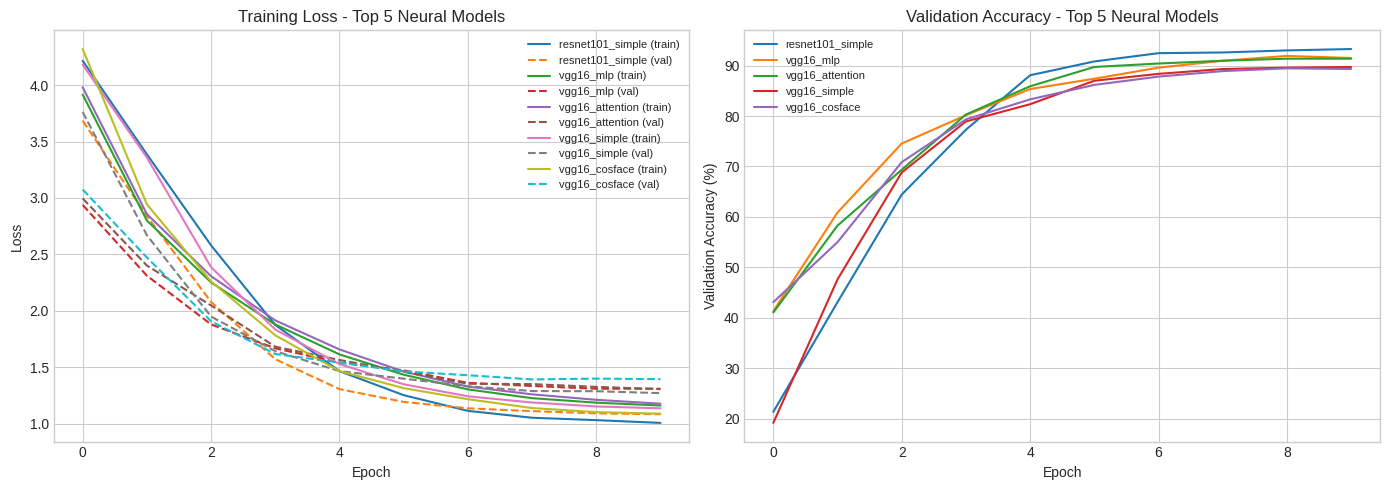

In [23]:
# Training curves for top 5 NEURAL models (classical don't have training curves)
neural_df = results_df[results_df['Type'] == 'Neural']
top_5_neural = neural_df.head(5)['Model'].tolist() if len(neural_df) > 0 else []

if len(top_5_neural) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for model_name in top_5_neural:
        if model_name in all_results:
            history = all_results[model_name].get('history', {})
            if history.get('train_loss'):
                axes[0].plot(history['train_loss'], label=f"{model_name} (train)")
            if history.get('val_loss'):
                axes[0].plot(history['val_loss'], '--', label=f"{model_name} (val)")

    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss - Top 5 Neural Models')
    axes[0].legend(fontsize=8)

    for model_name in top_5_neural:
        if model_name in all_results:
            history = all_results[model_name].get('history', {})
            if history.get('val_acc'):
                axes[1].plot(history['val_acc'], label=model_name)

    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Accuracy (%)')
    axes[1].set_title('Validation Accuracy - Top 5 Neural Models')
    axes[1].legend(fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(WORK_DIR, 'part2_training_curves_top5.png'), dpi=150)
    plt.show()
else:
    print("No neural models with training history to plot.")

In [24]:
# Best model summary (from all models - neural and classical)
best_model_name = results_df.iloc[0]['Model']
best_results = all_results[best_model_name]
best_type = results_df.iloc[0]['Type']

print("\n" + "="*60)
print("BEST MODEL SUMMARY")
print("="*60)
print(f"Model:           {best_model_name}")
print(f"Type:            {best_type}")
print(f"Backbone:        {best_results.get('backbone', 'N/A')}")
print(f"Classifier Head: {best_results.get('head', 'N/A')}")
print(f"")
print(f"Training Accuracy:    {best_results.get('final_train_acc', 0):.2f}%")
print(f"Validation Accuracy:  {best_results.get('best_val_acc', 0):.2f}%")
print(f"Top-5 Accuracy:       {best_results.get('final_val_top5', 0):.2f}%")
print(f"F1 Score:             {best_results.get('final_val_f1', 0):.4f}")
print(f"AUC-ROC:              {best_results.get('final_val_auc', 0):.4f}")
print("="*60)

# Also show best from each category
print("\n" + "="*60)
print("BEST MODEL BY CATEGORY")
print("="*60)

# Best Neural
neural_models = results_df[results_df['Type'] == 'Neural']
if len(neural_models) > 0:
    best_neural = neural_models.iloc[0]
    print(f"\nBest Neural Model: {best_neural['Model']}")
    print(f"  Accuracy: {best_neural['Best Val Acc']:.2f}%")
    print(f"  F1: {best_neural['Val F1']:.4f}")
    print(f"  AUC: {best_neural['AUC-ROC']:.4f}")

# Best Classical
classical_models = results_df[results_df['Type'] == 'Classical']
if len(classical_models) > 0:
    best_classical = classical_models.iloc[0]
    print(f"\nBest Classical Model: {best_classical['Model']}")
    print(f"  Accuracy: {best_classical['Best Val Acc']:.2f}%")
    print(f"  F1: {best_classical['Val F1']:.4f}")
    print(f"  AUC: {best_classical['AUC-ROC']:.4f}")

# Best by Backbone
print("\nBest by Backbone:")
for backbone in BACKBONES:
    backbone_models = results_df[results_df['Backbone'] == backbone]
    if len(backbone_models) > 0:
        best = backbone_models.iloc[0]
        print(f"  {backbone}: {best['Model']} ({best['Best Val Acc']:.2f}%)")

print("="*60)


BEST MODEL SUMMARY
Model:           resnet101_simple
Type:            Neural
Backbone:        resnet101
Classifier Head: simple

Training Accuracy:    97.47%
Validation Accuracy:  93.30%
Top-5 Accuracy:       97.81%
F1 Score:             0.9304
AUC-ROC:              0.9991

BEST MODEL BY CATEGORY

Best Neural Model: resnet101_simple
  Accuracy: 93.30%
  F1: 0.9304
  AUC: 0.9991

Best Classical Model: efficientnet_b3_svm_linear
  Accuracy: 55.81%
  F1: 0.5186
  AUC: 0.9541

Best by Backbone:
  vgg16: vgg16_mlp (91.93%)
  resnet101: resnet101_simple (93.30%)
  efficientnet_b3: efficientnet_b3_cosface (74.83%)


## 6. Save Best Model for Video Inference

In [25]:
# Save best model in the format compatible with video inference
best_model_path = os.path.join(MODELS_DIR, 'best_face_recognition.pt')

# Check if best model is neural or classical
is_best_classical = best_results.get('classifier_type') == 'classical'

if is_best_classical:
    # For classical models, save differently
    best_model_path = os.path.join(MODELS_DIR, 'best_face_recognition_classical.joblib')
    
    # Get the trained classifier
    if best_model_name in trained_classifiers:
        best_save_dict = {
            'classifier': trained_classifiers[best_model_name],
            'backbone': best_results['backbone'],
            'classifier_type': best_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_results['best_val_acc'],
            'scaler_path': backbone_features[best_results['backbone']]['scaler_path'],
            'results': best_results
        }
        joblib.dump(best_save_dict, best_model_path)
        print(f"Best classical model saved to: {best_model_path}")
    else:
        print("Warning: Best classical model not found in trained_classifiers")
else:
    # For neural models
    if best_model_name in all_model_states:
        best_save_dict = {
            'model_state_dict': all_model_states[best_model_name],
            'backbone': best_results['backbone'],
            'head': best_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_results['best_val_acc'],
            'results': best_results
        }
        torch.save(best_save_dict, best_model_path)
        print(f"Best neural model saved to: {best_model_path}")
    else:
        print("Warning: Best neural model state not found")

# Also save class names as JSON
class_names_path = os.path.join(MODELS_DIR, 'class_names.json')
with open(class_names_path, 'w') as f:
    json.dump(class_names, f, indent=2)
print(f"Class names saved to: {class_names_path}")

# Save best neural model specifically (for video inference compatibility)
neural_df = results_df[results_df['Type'] == 'Neural']
if len(neural_df) > 0:
    best_neural_name = neural_df.iloc[0]['Model']
    if best_neural_name in all_model_states:
        best_neural_results = all_results[best_neural_name]
        best_neural_path = os.path.join(MODELS_DIR, 'best_neural_face_recognition.pt')
        torch.save({
            'model_state_dict': all_model_states[best_neural_name],
            'backbone': best_neural_results['backbone'],
            'head': best_neural_results['head'],
            'num_classes': num_classes,
            'class_names': class_names,
            'best_val_acc': best_neural_results['best_val_acc'],
            'results': best_neural_results
        }, best_neural_path)
        print(f"Best neural model saved to: {best_neural_path}")

Best neural model saved to: /kaggle/working/models_part2/best_face_recognition.pt
Class names saved to: /kaggle/working/models_part2/class_names.json
Best neural model saved to: /kaggle/working/models_part2/best_neural_face_recognition.pt


In [26]:
# ============================================================
# SAVE ALL RESULTS AS JSON
# ============================================================

json_output = []

for model_key, metrics in all_results.items():
    # Get history
    history = metrics.get('history', {})
    
    # Determine if this is a neural or classical model
    is_classical = metrics.get('classifier_type') == 'classical'
    
    model_data = {
        'model_name': model_key,
        'backbone': metrics.get('backbone', 'unknown'),
        'classifier': metrics.get('head', 'unknown'),
        'classifier_type': 'classical' if is_classical else 'neural',
        'epochs': len(history.get('train_loss', [])) if not is_classical else 0,
        'backbone_training': {
            'train_loss': history.get('train_loss', []),
            'val_loss': history.get('val_loss', []),
            'train_accuracy': history.get('train_acc', []),
            'val_accuracy': history.get('val_acc', [])
        },
        'classifier_metrics': {
            'train_accuracy': float(metrics.get('final_train_acc', 0.0)),
            'test_accuracy': float(metrics.get('final_val_acc', 0.0)),
            'best_accuracy': float(metrics.get('best_val_acc', 0.0)),
            'precision': float(metrics.get('val_precision', 0.0)) if is_classical else 0.0,
            'recall': float(metrics.get('val_recall', 0.0)) if is_classical else 0.0,
            'f1': float(metrics.get('final_val_f1', 0.0)),
            'top5_accuracy': float(metrics.get('final_val_top5', 0.0)),
            'auc_roc': float(metrics.get('final_val_auc', 0.0))
        }
    }
    
    # Add training time for classical classifiers
    if is_classical:
        model_data['training_time_seconds'] = float(metrics.get('train_time', 0.0))
    else:
        model_data['training_time_seconds'] = float(metrics.get('training_time', 0.0))
    
    json_output.append(model_data)

# Sort by test accuracy
json_output = sorted(json_output, key=lambda x: x['classifier_metrics']['test_accuracy'], reverse=True)

# Save to JSON file
output_file = os.path.join(WORK_DIR, 'part2_model_results.json')
with open(output_file, 'w') as f:
    json.dump(json_output, f, indent=4)

print(f"\n{'='*60}")
print("JSON RESULTS SAVED")
print(f"{'='*60}")
print(f"Results saved to: {output_file}")
print(f"Total models saved: {len(json_output)}")
print(f"\nTop 5 Models by Validation Accuracy:")
for i, model in enumerate(json_output[:5], 1):
    print(f"  {i}. {model['model_name']}: {model['classifier_metrics']['test_accuracy']:.2f}% | F1: {model['classifier_metrics']['f1']:.4f} | AUC: {model['classifier_metrics']['auc_roc']:.4f}")
print(f"{'='*60}")


JSON RESULTS SAVED
Results saved to: /kaggle/working/part2_model_results.json
Total models saved: 27

Top 5 Models by Validation Accuracy:
  1. resnet101_simple: 93.30% | F1: 0.9304 | AUC: 0.9991
  2. vgg16_mlp: 91.52% | F1: 0.9109 | AUC: 0.9987
  3. vgg16_attention: 91.38% | F1: 0.9081 | AUC: 0.9991
  4. vgg16_simple: 89.74% | F1: 0.8933 | AUC: 0.9986
  5. vgg16_cosface: 89.33% | F1: 0.8868 | AUC: 0.9978


In [27]:
print("\n" + "="*60)
print("PART 2 TRAINING COMPLETE!")
print("="*60)

# Count models by type
neural_count = len([r for r in all_results.values() if r.get('classifier_type') != 'classical'])
classical_count = len([r for r in all_results.values() if r.get('classifier_type') == 'classical'])

print(f"\nTotal models trained: {len(all_results)}")
print(f"  - Neural Network models: {neural_count}")
print(f"  - Classical ML models:   {classical_count}")
print(f"\nBackbones used: {BACKBONES}")
print(f"Neural heads:   {NEURAL_HEADS}")
print(f"Classical:      {list(CLASSICAL_CLASSIFIERS.keys())}")

print(f"\nBest overall model: {best_model_name}")
print(f"Best accuracy: {best_results.get('best_val_acc', 0):.2f}%")
print(f"Best F1 Score: {best_results.get('final_val_f1', 0):.4f}")
print(f"Best AUC-ROC: {best_results.get('final_val_auc', 0):.4f}")

print(f"\nFiles saved:")
print(f"  - Best model: {best_model_path}")
print(f"  - Class names: {class_names_path}")
print(f"  - All results (JSON): {os.path.join(WORK_DIR, 'part2_model_results.json')}")
print(f"  - Individual models in: {MODELS_DIR}/")
print(f"\nModel naming convention: <backbone>_<classifier>_run1.pt/.joblib")
print("="*60)


PART 2 TRAINING COMPLETE!

Total models trained: 27
  - Neural Network models: 15
  - Classical ML models:   12

Backbones used: ['vgg16', 'resnet101', 'efficientnet_b3']
Neural heads:   ['simple', 'mlp', 'deep', 'attention', 'cosface']
Classical:      ['svm_rbf', 'svm_linear', 'random_forest', 'xgboost']

Best overall model: resnet101_simple
Best accuracy: 93.30%
Best F1 Score: 0.9304
Best AUC-ROC: 0.9991

Files saved:
  - Best model: /kaggle/working/models_part2/best_face_recognition.pt
  - Class names: /kaggle/working/models_part2/class_names.json
  - All results (JSON): /kaggle/working/part2_model_results.json
  - Individual models in: /kaggle/working/models_part2/

Model naming convention: <backbone>_<classifier>_run1.pt/.joblib
